In [9]:
import matplotlib.pyplot as plt
import scipy.special

In [56]:
import os
import pickle
import warnings

import numpy as np
import networkx as nx
from tqdm import tqdm, tqdm_notebook

import keras
from keras_tqdm import TQDMNotebookCallback as TQDMCallback

from nw2vec import layers
from nw2vec import ae
from nw2vec import utils
from nw2vec import batching
import settings

In [36]:
# ### PARAMETERS ###

# Data
n_communities = 100
community_size = 20
p_in = .4
p_out = .01
features_noise_scale = 0

# Model
n_ξ_samples = 1
dim_l1, dim_ξ = 10, 10
use_bias = False

# Training
n_epochs = 10000
# seeds_per_batch = 10
max_walk_length = 1
p = 1
q = 1
neighbour_samples = 30

In [3]:
# ### MISC. SETUP VARIABLES ###

#if 'CUDA_VISIBLE_DEVICES' not in os.environ:
#    raise ValueError('CUDA_VISIBLE_DEVICES not set')
#MODEL_NAME = os.path.split(__file__)[-1][:-3]
#MODEL_PATH = os.path.join(settings.BEHAVIOUR_PATH, MODEL_NAME)
#if not os.path.exists(MODEL_PATH):
#    os.mkdir(MODEL_PATH)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


# ### DEFINE TRAINING DATA ###

g = nx.planted_partition_graph(n_communities, community_size, p_in, p_out)
labels = np.zeros((n_communities * community_size, n_communities), dtype=np.float32)
for c in range(n_communities):
    labels[range(c * community_size, (c + 1) * community_size), c] = 1
features = (labels + np.abs(np.random.normal(loc=0.0,
                                             scale=features_noise_scale,
                                             size=(n_communities * community_size,
                                                   n_communities))
                            .astype(np.float32)))

# ## Update model parameters ##
seeds_per_batch = len(g.nodes)
dim_data = n_communities
dims = (dim_data, dim_l1, dim_ξ)
# DATA_PARAMETERS = (
#     'n_communities={n_communities}'
#     '-community_size={community_size}'
#     '-p_in={p_in}'
#     '-p_out={p_out}'
#     '-features_noise_scale={features_noise_scale}').format(n_communities=n_communities,
#                                                            community_size=community_size,
#                                                            p_in=p_in, p_out=p_out,
#                                                            features_noise_scale=features_noise_scale)
# VAE_PARAMETERS = (
#     'n_ξ_samples={n_ξ_samples}'
#     '-dims={dims}'
#     '-bias={use_bias}').format(n_ξ_samples=n_ξ_samples,
#                                dims=dims, use_bias=use_bias)
# TRAINING_PARAMETERS = (
#     'seeds_per_batch={seeds_per_batch}'
#     '-WL={max_walk_length}'
#     '-p={p}'
#     '-q={q}'
#     '-neighbour_samples={neighbour_samples}'
#     '-n_epochs={n_epochs}'
#     '-run={run}').format(seeds_per_batch=seeds_per_batch,
#                          max_walk_length=max_walk_length,
#                          p=p, q=q,
#                          neighbour_samples=neighbour_samples,
#                          n_epochs=n_epochs,
#                          run=run)
# MODEL_DATA = os.path.join(MODEL_PATH,
#                           DATA_PARAMETERS + '---' +
#                           VAE_PARAMETERS + '---' +
#                           TRAINING_PARAMETERS)
# MODEL_RESULTS = MODEL_DATA + '.results.pkl'
# if os.path.exists(MODEL_RESULTS):
#     warnings.warn('"{}" already exist, skipping.'.format(MODEL_RESULTS))
#     return

# ### BUILD THE VAE ###

adj = nx.adjacency_matrix(g).astype(np.float32)

def build_q(dims, use_bias=False):
    dim_data, dim_l1, dim_ξ = dims

    q_input = keras.layers.Input(shape=(dim_data,), name='q_input')
    # CANDO: change activation
    q_layer1_placeholders, q_layer1 = ae.gc_layer_with_placeholders(
        dim_l1, 'q_layer1', {'use_bias': use_bias, 'activation': 'relu'}, q_input)
    q_μ_flat_placeholders, q_μ_flat = ae.gc_layer_with_placeholders(
        dim_ξ, 'q_mu_flat', {'use_bias': use_bias, 'gather_mask': True}, q_layer1)
    q_logD_flat_placeholders, q_logD_flat = ae.gc_layer_with_placeholders(
        dim_ξ, 'q_logD_flat', {'use_bias': use_bias, 'gather_mask': True}, q_layer1)
    q_μlogD_flat = keras.layers.Concatenate(name='q_mulogD_flat')(
        [q_μ_flat, q_logD_flat])
    q_model = ae.Model(inputs=([q_input]
                               + q_layer1_placeholders
                               + q_μ_flat_placeholders
                               + q_logD_flat_placeholders),
                       outputs=q_μlogD_flat)

    return q_model, ('OrthogonalGaussian',)

q_model, q_codecs = build_q(dims, use_bias=use_bias)

def p_builder(p_input):
    # CANDO: change activation
    p_layer1 = keras.layers.Dense(dim_l1, use_bias=use_bias, activation='relu',
                                  kernel_regularizer='l2', bias_regularizer='l2',
                                  name='p_layer1')(p_input)
    p_adj = layers.Bilinear(0, use_bias=use_bias,
                            kernel_regularizer='l2', bias_regularizer='l2',
                            name='p_adj')([p_layer1, p_layer1])
    p_v = keras.layers.Dense(dim_data, use_bias=use_bias,
                             kernel_regularizer='l2', bias_regularizer='l2',
                             name='p_v')(p_layer1)
    return ([p_adj, p_v], ('SigmoidBernoulliScaledAdjacency', 'SigmoidBernoulli'))

vae, vae_codecs = ae.build_vae(
    (q_model, q_codecs),
    p_builder,
    n_ξ_samples,
    [
        1.0,  # q
        1.0,  # p adj
        1.0,  # p vars
    ]
)

# ### DEFINE TRAINING OBJECTIVES ###

def target_func(batch_adj, required_nodes, final_nodes):
    return [
        np.zeros(1),  # ignored
        utils.expand_dims_tile(
            utils.expand_dims_tile(batch_adj + np.eye(batch_adj.shape[0]),
                                   0, n_ξ_samples),
            0, 1
        ),
        utils.expand_dims_tile(labels[final_nodes], 1, n_ξ_samples),
    ]

# ### TRAIN ###

steps_per_epoch = int(np.ceil(len(features) / seeds_per_batch))

history = vae.fit_generator_feed(
    batching.batches(vae, adj, labels, target_func,
                     seeds_per_batch, max_walk_length,
                     p=p, q=q, neighbour_samples=neighbour_samples),
    steps_per_epoch=steps_per_epoch,
    epochs=n_epochs,
    check_array_lengths=False,
    shuffle=False,
    verbose=0,
    callbacks=[
        keras.callbacks.TensorBoard(),
        TQDMCallback(show_inner=False),
    ]
)

/home/slerique/anaconda3/envs/base36-grunchgpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/slerique/anaconda3/envs/base36-grunchgpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/slerique/anaconda3/envs/base36-grunchgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Types of pairs

In [42]:
def pair_types(n_communities, community_size):
    return {
        # Same community, connected
        (True, True): scipy.special.binom(community_size, 2) * p_in * n_communities,
        # Different communities, connected
        (False, True): community_size ** 2 * p_out * scipy.special.binom(n_communities, 2),
        # Same community, disconnected
        (True, False): scipy.special.binom(community_size, 2) * (1 - p_in) * n_communities,
        # Different communities, disconnected
        (False, False): community_size ** 2 * (1 - p_out) * scipy.special.binom(n_communities, 2),
    }

In [60]:
n_grid = np.arange(10, 101)
m_grid = np.arange(20, 101)
minibatch_size = np.zeros(n_grid.shape + m_grid.shape)
for i, n in tqdm_notebook(enumerate(n_grid)):
    for j, m in enumerate(m_grid):
        pt = pair_types(n, m)
        minibatch_size[i, j] = scipy.special.binom(n * m, 2) / np.min(list(pt.values()))

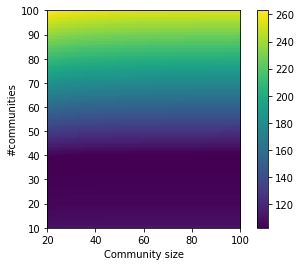

In [61]:
plt.imshow(minibatch_size, origin='lower', extent=(m_grid.min(), m_grid.max(), n_grid.min(), n_grid.max()))
plt.xlabel('Community size')
plt.ylabel('#communities')
plt.colorbar()

## Results - right size minibatch

**TODO**: Sample random pairs of each category, with at least 1 in the least-probable category (and the rest should be scaled accordingly).

## Results - full batch

```python
# Training
n_epochs = 10000
# seeds_per_batch = 10
max_walk_length = 1
p = 1
q = 1
neighbour_samples = 30
```

In [4]:
history = {'history': history.history}

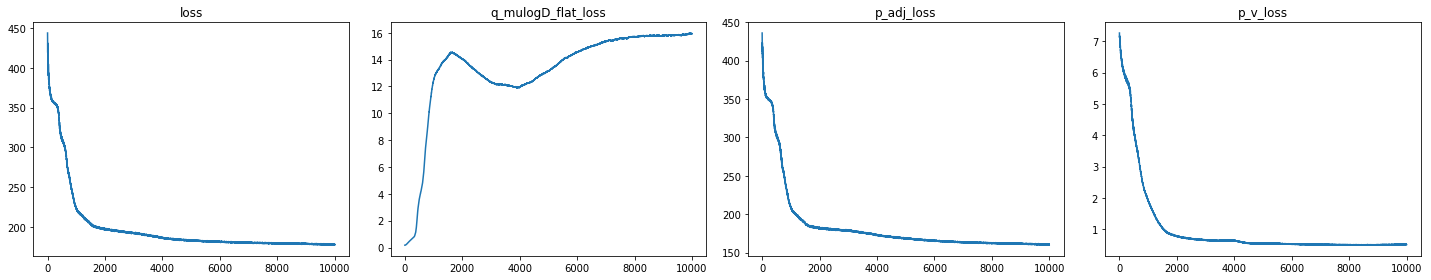

In [7]:
fig, axes = plt.subplots(1, len(history['history']), figsize=(len(history['history']) * 5, 4))
for i, (title, values) in enumerate(history['history'].items()):
    axes[i].plot(values)
    axes[i].set_title(title)
#axes[-1].set_ylim(-2000, 50)
fig.tight_layout()

In [10]:
x, _, feeds = next(batching.batches(vae, adj, labels, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))

q_preds, adj_preds, v_preds = zip(*[vae.predict_on_fed_batch(x, feeds=feeds) for _ in range(10)])

q_preds = np.array(q_preds)
adj_preds = np.array(adj_preds)
v_preds = np.array(v_preds)

q_pred = q_preds.mean(0)
adj_pred = scipy.special.expit(adj_preds[:, 0, :, :, :]).mean(1).mean(0)
v_pred = scipy.special.expit(v_preds[:, :, :, :]).mean(2).mean(0)

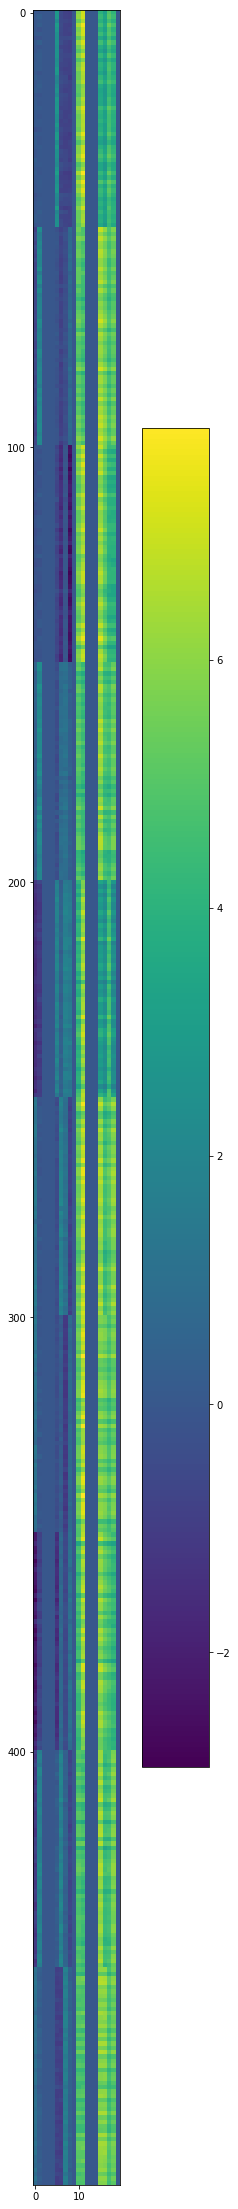

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, (len(g.nodes) / 100) * 8))
im = ax.imshow(q_pred)
plt.colorbar(im, ax=ax)

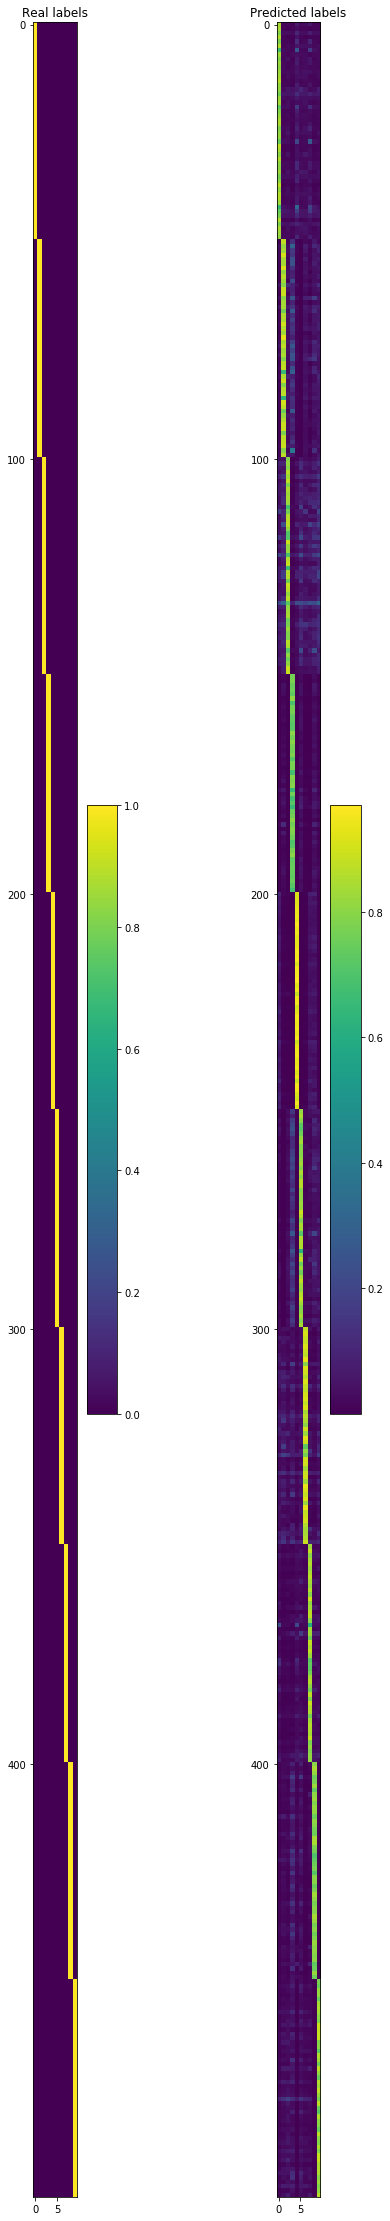

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, (len(g.nodes) / 100) * 8))

im1 = ax1.imshow(labels)
ax1.set_title('Real labels')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(v_pred)
#im2.set_norm(im1.norm)
ax2.set_title('Predicted labels')
plt.colorbar(im2, ax=ax2);

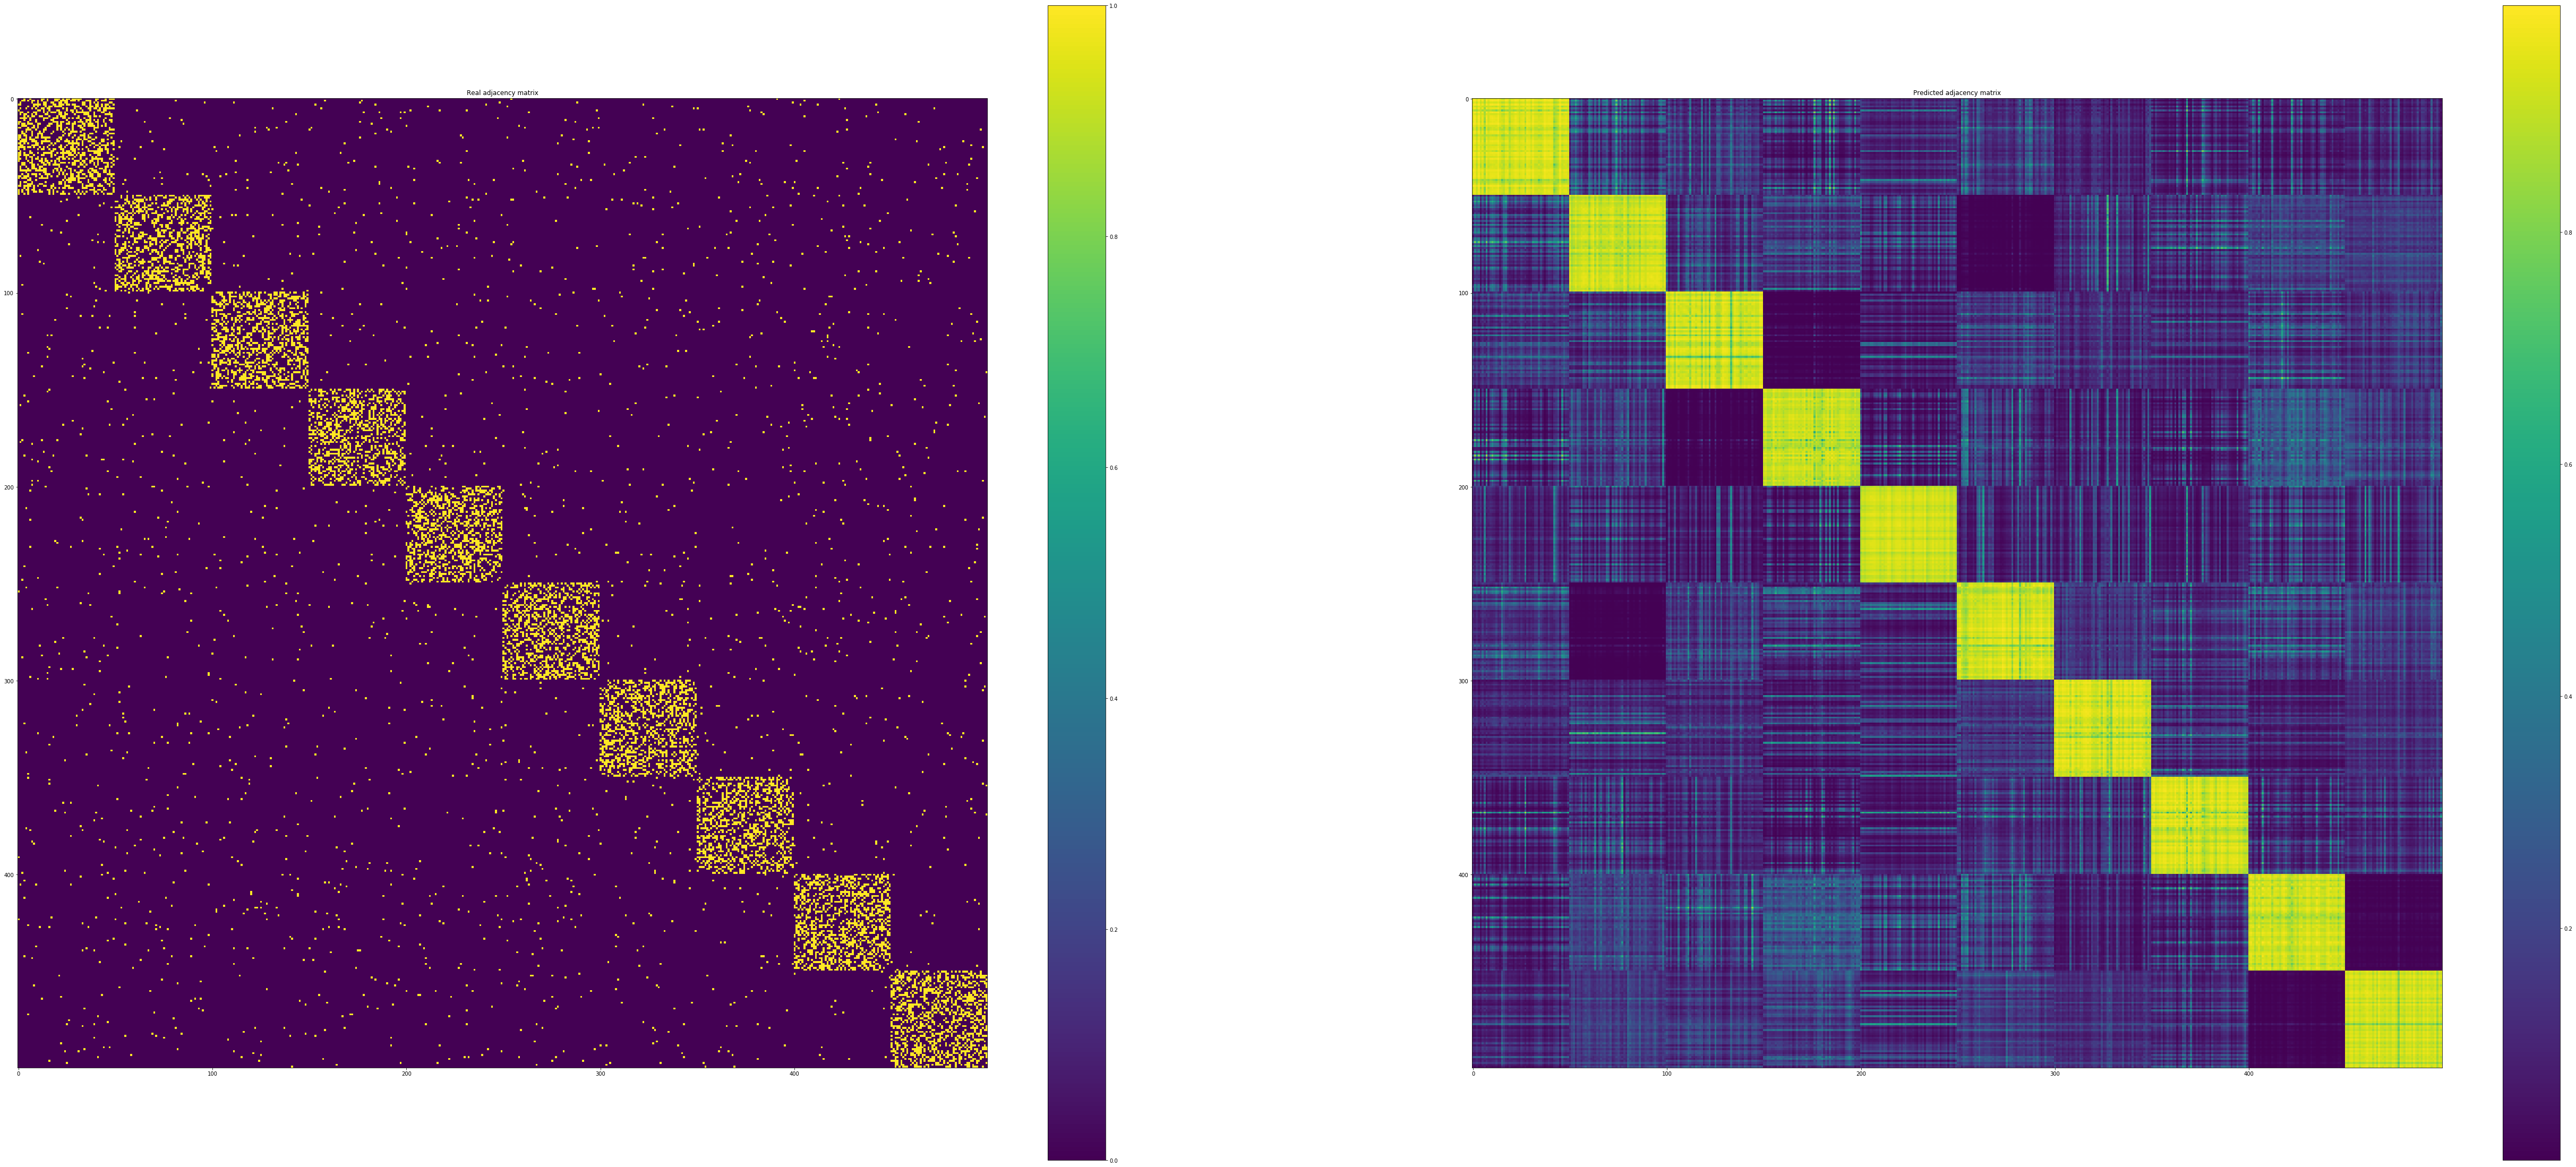

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=((len(g.nodes) / 100) * 18, (len(g.nodes) / 100) * 8))

im1 = ax1.imshow(adj.toarray())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(adj_pred)
#im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

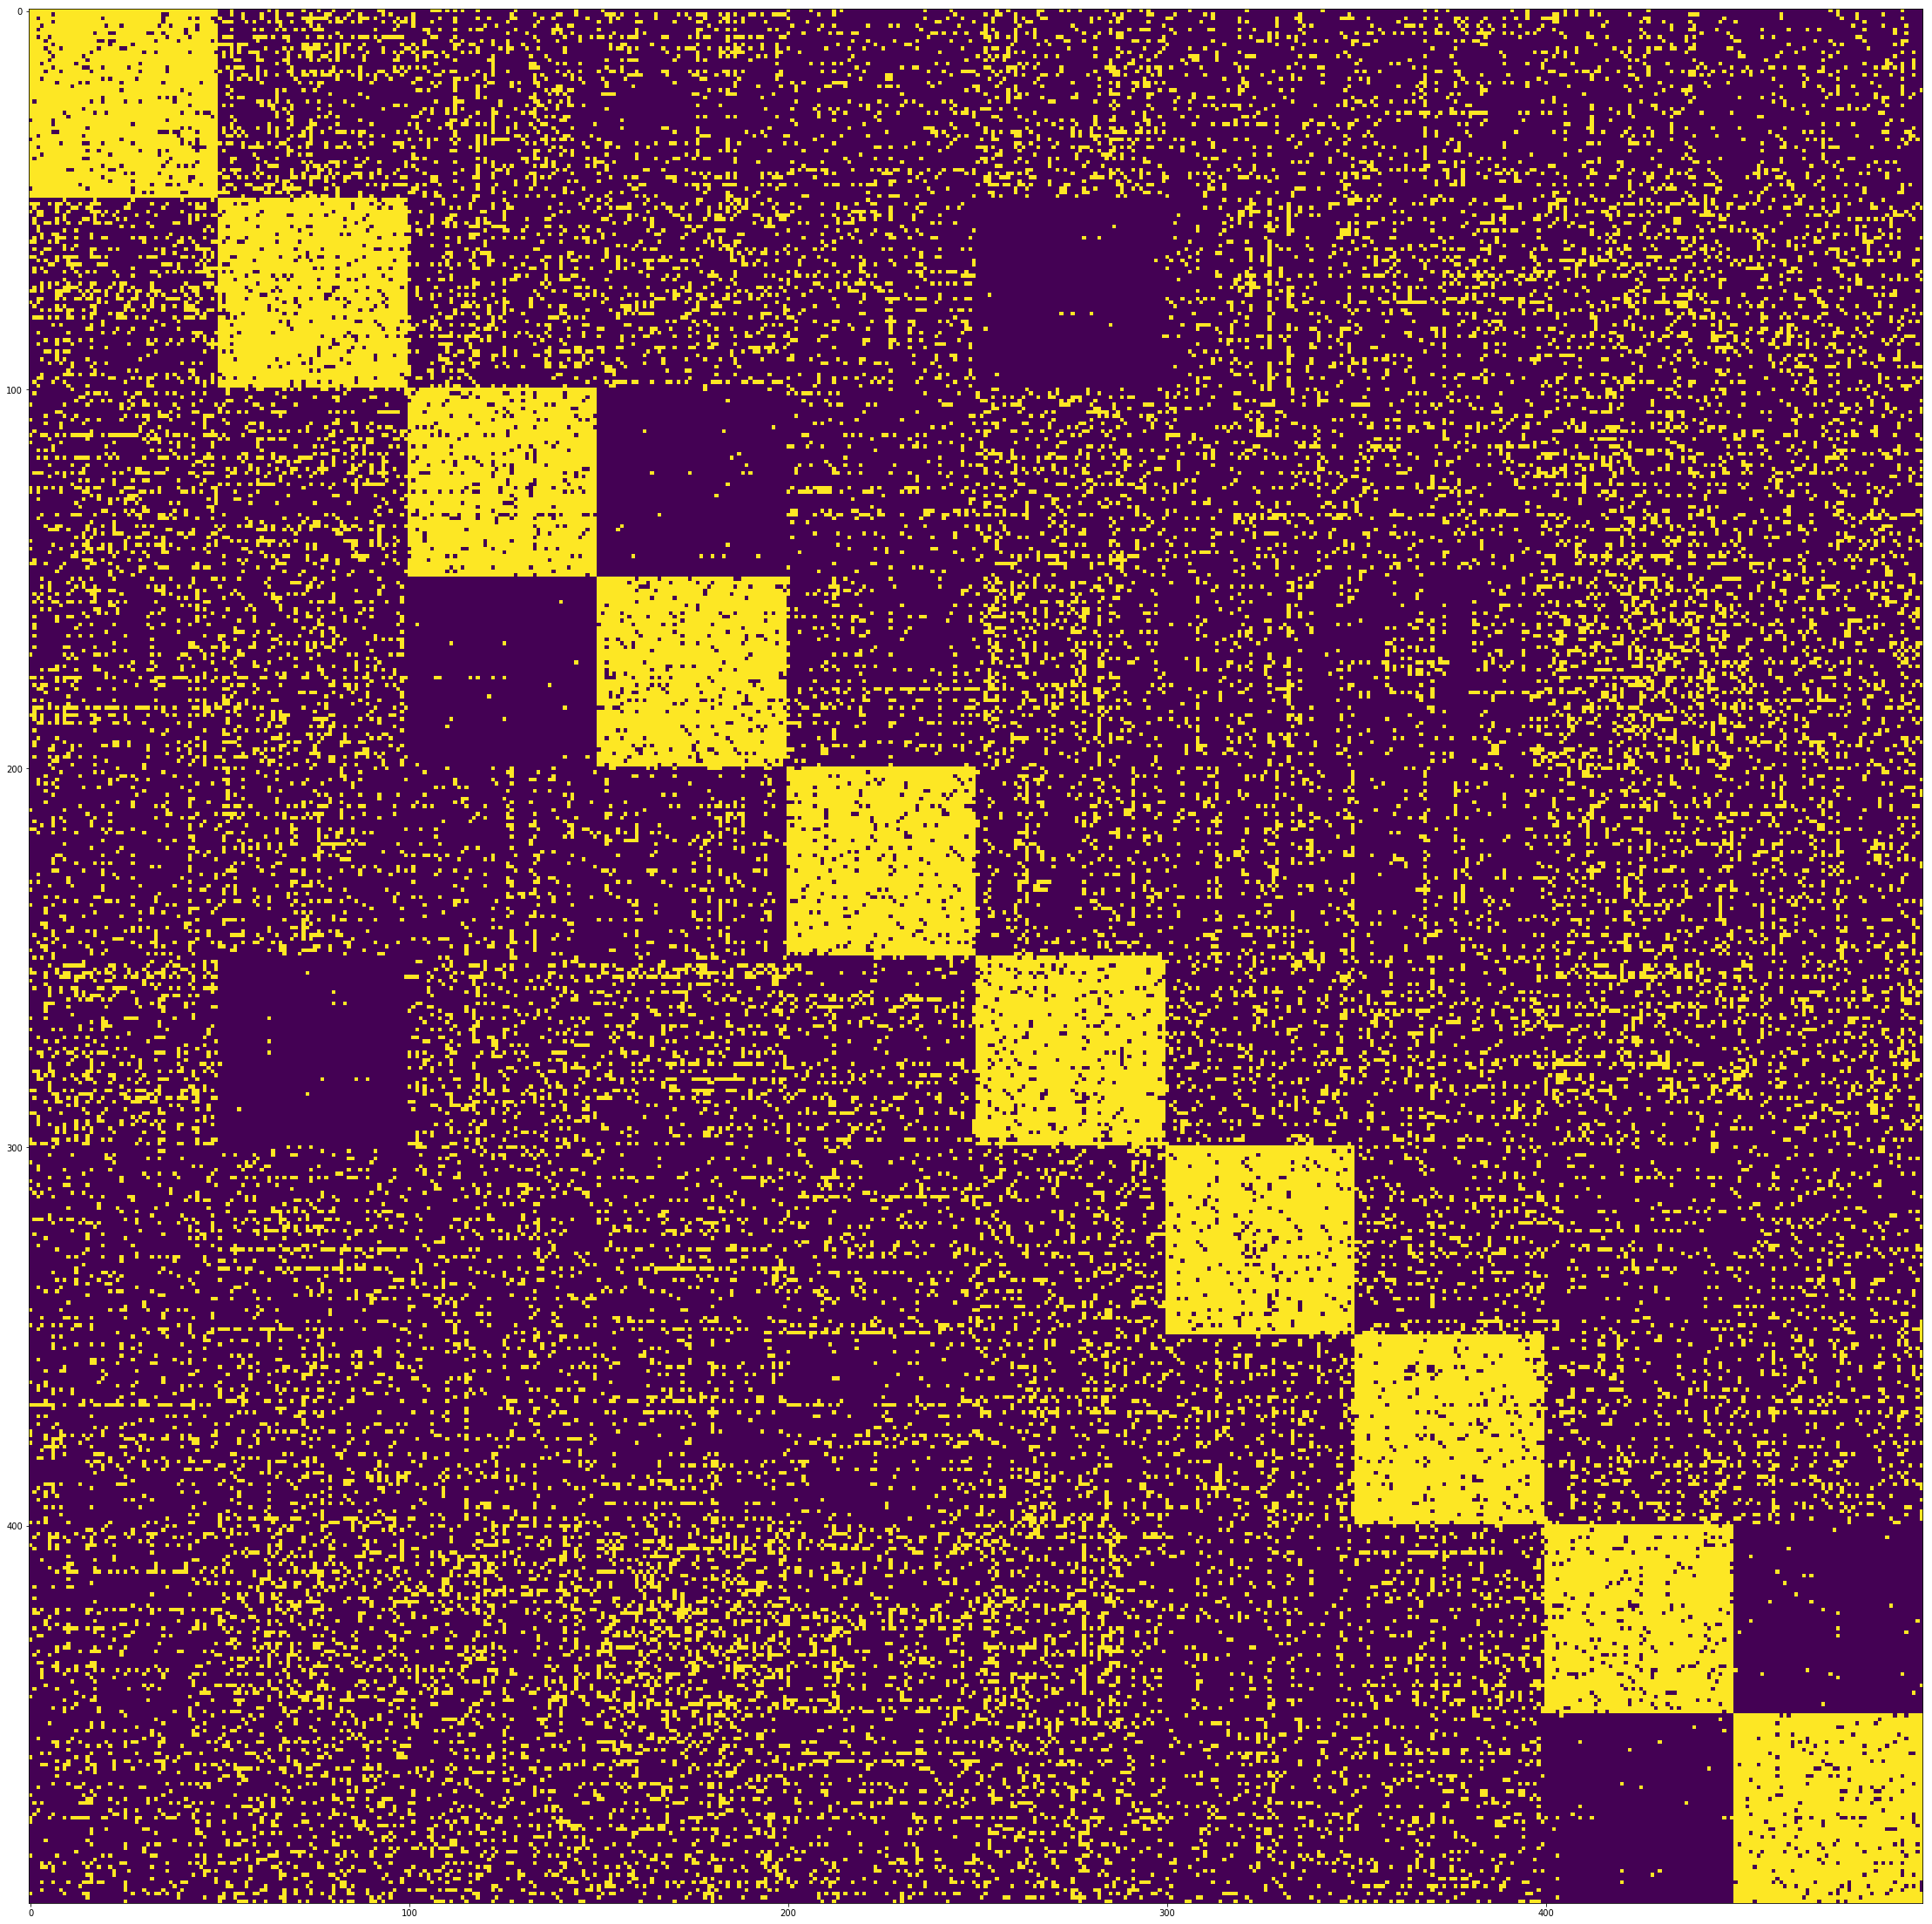

In [15]:
fig, ax = plt.subplots(1, 1, figsize=((len(g.nodes) / 100) * 8, (len(g.nodes) / 100) * 8))
ax.imshow(np.random.binomial(1, adj_pred))

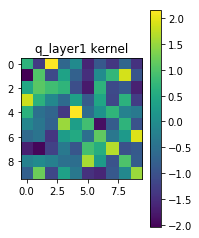

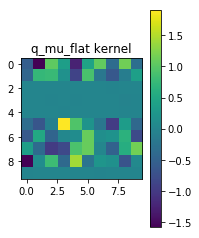

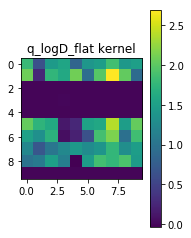

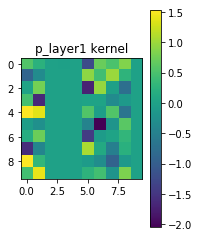

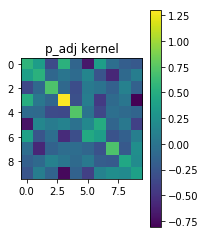

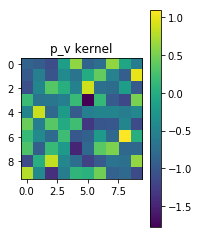

In [16]:
from keras import backend as K

for layer in vae.layers:
    if hasattr(layer, 'kernel'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))#, sharey=True)
        im1 = ax1.imshow(K.eval(layer.kernel).T)
        ax1.set_title('{} kernel'.format(layer.name))
        plt.colorbar(im1, ax=ax1)
    if hasattr(layer, 'bias') and layer.bias is not None:
        im2 = ax2.imshow(K.eval(K.expand_dims(layer.bias, -1)))
        ax2.set_title('{} bias'.format(layer.name))
        plt.colorbar(im2, ax=ax2)
    else:
        ax2.set_visible(False)